# **Data Loading**

In [3]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [4]:
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm import tqdm

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [7]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# **Data Exploration**

In [8]:
df_train.shape

(188533, 13)

In [9]:
duplicate_rows = df_train[df_train.duplicated(keep=False)]

if duplicate_rows.shape[0] > 0:
    print(f'Duplicate Rows:\n{duplicate_rows}')
else:
    print('No Duplicate Rows')

No Duplicate Rows


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [11]:
for column in df_train.drop(columns=['id', 'price']).columns:
    print(df_train[column].value_counts(dropna=False))
    print('_'*40)

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

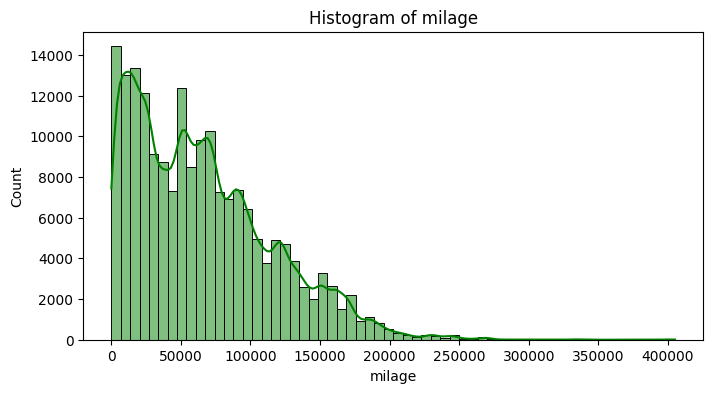

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train['milage'], kde=True, bins=60, color='green')
plt.title('Histogram of milage')
plt.show()

# **Data Cleaning and Feature Engineering**

In [13]:
common_colors_mapping = {
    'black': ['black', 'blk', 'nero', 'graphite', 'ebony', 'obsidian', 
              'anthracite', 'onyx', 'beluga', 'caviar'],
    'grey': ['grey', 'gray', 'slate', 'galvanized', 'boulder', 'charcoal',
             'ash', 'shale', 'chateau', 'pewter', 'portland', 'grigio', 
             'steel', 'rock', 'magno', 'granite'],
    'brown': ['brown', 'walnut', 'espresso', 'roast', 'caramel', 'mocha', 
              'chestnut', 'cocoa', 'porpoise', 'auburn'],
    'red': ['red', 'garnet', 'hotspur', 'pimento', 'sport', 'rosso', 
            'maroon', 'scarlet', 'ember', 'ruby'],
    'blue': ['blue', 'navy', 'ice', 'sapphire', 'tempest', 'blu', 'glacier', 
             'nightfall', 'sea'],
    'green': ['green', 'cypress', 'emerald', 'gideon', 'tupelo', 'geckopearl', 
              'verde', 'moss'],
    'yellow': ['yellow', 'gold', 'amber', 'giallo', 'hellayella'],
    'orange': ['orange', 'tension', 'mesa', 'sunset', 'mango', 'arancio'],
    'beige': ['beige', 'parchment', 'cappuccino', 'tan', 'macchiato', 'camel', 
              'stone', 'brandy', 'ceramic'],
    'purple': ['purple', 'orchid'],
    'pink': ['pink'],
    'silver': ['silver', 'platinum', 'cloud', 'titanium', 'metallic'],
    'white': ['white', 'ivory', 'polar', 'linen', 'oyster', 'bianco', 'chalk', 
              'pearl', 'yulong'],
}

In [14]:
def map_color(color):
    for common_color, variations in common_colors_mapping.items():
        if any(variation in color for variation in variations):
            return common_color
    return 'other'

In [15]:
def colors_to_common(df, column_name):
    df[column_name] = df[column_name].str.strip().str.lower().str.replace(' ', '').str.replace('/', '')
    df[column_name] = df[column_name].apply(map_color)

In [16]:
def categorize_mileage(mileage):
    if mileage < 20000:
        return 'Low mileage'
    elif 20000 <= mileage < 60000:
        return 'Moderate mileage'
    elif 60000 <= mileage < 100000:
        return 'Average mileage'
    elif 100000 <= mileage < 200000:
        return 'High mileage'
    else:
        return 'Very high mileage' 

In [17]:
def categorize_transmission(transmission):
    automatic_keywords = r'a/t|at|automatic|cvt|dct|overdrive|variable'
    manual_keywords = r'm/t|manual|mt|fixed'
    dual_keywords = r'dual'

    is_automatic = transmission.str.contains(automatic_keywords, na=False)
    is_manual = transmission.str.contains(manual_keywords, na=False)
    is_dual = transmission.str.contains(dual_keywords, na=False)
    
    transmission = np.where(is_automatic, 'Automatic', transmission)
    transmission = np.where(is_manual, 'Manual', transmission)
    transmission = np.where(is_dual, 'Dual', transmission)

    transmission = np.where(~is_automatic & ~is_manual & ~is_dual, 'Unknown', transmission)
    
    return transmission

In [18]:
def categorize_engine(row):
    hp = None  # horsepower
    displacement = None  
    fuel_type = None
    cylinders = None
    
    hp_match = re.search(r'(\d+\.?\d*)HP', row)
    displacement_match = re.search(r'(\d+\.?\d*)L|(\d+\.?\d*) Liter', row)

    if hp_match:
        hp = float(hp_match.group(1))

    if displacement_match:
        displacement = float(displacement_match.group(1) if displacement_match.group(1) else displacement_match.group(2))

    if 'Electric Motor' in row:
        fuel_type = 'Electric'
    elif 'Gasoline' in row:
        fuel_type = 'Gasoline'
    elif 'Diesel' in row:
        fuel_type = 'Diesel'
    elif 'Hybrid' in row:
        fuel_type = 'Hybrid'
    else:
        fuel_type = 'Unknown'  

    cylinders_match = re.search(r'(\d+ Cylinder|V\d)', row)
    if cylinders_match:
        cylinders = cylinders_match.group(0)
    else:
        cylinders = 'Unknown'  

    if hp is not None:
        engine_power = hp
    else:
        engine_power = 'Unknown'  

    if displacement is not None:
        engine_size = displacement
    else:
        engine_size = 'Unknown' 

    return pd.Series([engine_power, engine_size, fuel_type, cylinders])

In [19]:
def categorize_model(row):
        model = row['model_category']
        if any(keyword in model for keyword in ['rover', 'amg', 'xlr', '911', 'type', 'allroad', '850', '124', 'z3', '812', 'e-class', 'k900', 'c-class', 's-class', 'sl-class', 'm3', 'm4', 'm5', 'm6', 'm8', '335', '328', '435', '330', '650', '750', 'cts', 'is', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'panamera', 's4', 's5', '428', 'ls', 'tlx', 'r8', 'lc', 'cla-class', 'ghibli', 'bentayga']):
            return 'Luxury'
        elif any(keyword in model for keyword in ['f-150', 'f-250', 'f-350', '1500', '2500', 'tundra', 'ram', 'tacoma', 'silverado', 'sierra', 'transit-350', 'transit', 'sprinter', 'avalanche', 'colorado', 'dakota']):
            return 'Truck'
        elif any(keyword in model for keyword in ['suburban', 'escalade', 'expedition', 'gx', 'rx', 'bronco', 'tahoe', '4runner', 'qx60', 'yukon', 'sequoia', 'highlander', 'gladiator', 'explorer', 'wrangler', 'macan', 'cayenne', 'q5', 'q7', 'q8', 'gl-class', 'gls', 'glc', 'gle', 'g-class', 'navigator', 'telluride', 'acadia', 'mdx', 'qx80', 'sorento', 'r1s', 'lx', 'pathfinder', 'enclave', 'pilot', 'armada', 'edge', 'x3', 'x5', 'gv70', 'fj', 'cx-30']):
            return 'Sports Car'
        elif any(keyword in model for keyword in ['corvette', 'mustang', 'capri', 'camaro', '240sx', 'prowler', 'gr', 'challenger', 'rs', 'cayman', 'impreza', 'romeo', 'cayman', 'boxster', 'mx-5', 'charger', 'huracan', 'gt-r', '350z']):
            return 'Sports Car'
        elif any(keyword in model for keyword in ['500e', 'fortwo', 'insight', '740e', 'bz4x', 'e-golf', 'model', 'clarity', '500x', 'r1s', 'taycan']):
            return 'Electric/Hybrid'
        elif any(keyword in model for keyword in ['rio', 'mirage', 'cooper', 'golf', 'civic', 'focus', 'fusion', 'liberty', 'outback', 'jetta', 'optima', 'town', 'continental', 'avalon', 'sonata', 'escape', 'santa']):
            return 'Economy'
        else:
            return 'Other'

In [20]:
def categorize_brand(brand):
    very_expensive_brands = ['Rolls-Royce', 'Lamborghini', 'Ferrari', 
                             'McLaren', 'Aston', 'Bugatti', 'Maybach', 
                             'Lucid', 'Karma', 'Bentley']

    expensive_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 
                        'Land', 'Lexus', 'Tesla', 'INFINITI', 'Alfa',
                        'Jaguar', 'Cadillac', 'Maserati', 'Genesis', 
                        'Alfa Romeo', 'Volvo', 'Polestar', 'Lotus',
                        'Rivian']

    medium_price_brands = ['Ford', 'Chevrolet', 'Toyota', 'Jeep', 'RAM',
                           'GMC', 'Lincoln', 'Acura', 'Volkswagen', 'MINI',
                           'Buick', 'Chrysler']

    economic_brands = ['Nissan', 'Honda', 'Hyundai', 'Mazda', 'Kia', 'Dodge', 
                       'Subaru', 'Mitsubishi', 'Pontiac', 'Saturn', 'Scion', 
                       'FIAT', 'Suzuki', 'Hummer', 'Mercury', 'Saab', 'smart',
                       'Plymouth']

    if brand in very_expensive_brands:
        return 'Very Expensive'
    elif brand in expensive_brands:
        return 'Expensive'
    elif brand in medium_price_brands:
        return 'Medium Price'
    elif brand in economic_brands:
        return 'Economic'
    else:
        return 'Other'

In [21]:
def clean_df_columns(df, accident_mean, cylinder_configuration_mean, power_mean, size_mean):
    df['clean_title'].replace({'Yes': 1}, inplace=True)
    df['clean_title'].fillna(0, inplace=True)
    
    df['accident'].fillna(accident_mean, inplace=True) 
    
    df['vehicle_age'] = datetime.now().year - df['model_year']
    
    df['fuel_type_reduced'] = df['fuel_type'].replace({
         'E85 Flex Fuel': 'Gasoline',
         'Plug-In Hybrid': 'Hybrid',
         '–': np.nan,
         'not supported': np.nan
    })
    df['fuel_type_reduced'].fillna('Unknown', inplace=True)
    
    colors_to_common(df, 'int_col')
    colors_to_common(df, 'ext_col')
    
    df['mileage_category'] = df['milage'].apply(categorize_mileage)
    
    df['transmission'] = df['transmission'].str.lower()
    df['transmission'] = categorize_transmission(df['transmission'])
    
    df['cylinder_configuration'].replace({'Unknown': cylinder_configuration_mean}, inplace=True) 
    df['cylinder_configuration'] = df['cylinder_configuration'].astype(float)       
    
    df['engine_power'].replace({'Unknown': power_mean}, inplace=True) 
    df['engine_size'].replace({'Unknown': size_mean}, inplace=True) 
    
    df['model_category'] = df['model'].str.lower().str.split().str[0]
    df['model_category'] = df.apply(categorize_model, axis=1)
    
    df['brand_category'] = df['brand'].apply(categorize_brand)

    df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    df['mileage_per_year'].fillna(df['milage'], inplace=True)  # for new vehicles

    df['high_resale_value'] = df.apply(lambda x: 1 if x['clean_title'] == 1 and x['accident'] == 0 and x['milage'] < 50000 else 0, axis=1)

    df['vehicle_age_category'] = pd.cut(df['vehicle_age'], bins=[-1, 1, 6, 10, 40, 60], labels=['New', 'Almost New', 'Moderate', 'Old', 'Vintage'])

    df['recent_model'] = df['model_year'].apply(lambda x: 1 if x >= datetime.now().year - 2 else 0)

In [22]:
def parse_engine_column(df):
    df[['engine_power', 'engine_size', 'fuel_type_engine', 'cylinder_configuration']] = df['engine'].apply(categorize_engine)
    
    df['cylinder_configuration'].replace({'V6': '6', 'V8': '8', 'V1': '1'}, inplace=True) 
    df['cylinder_configuration'] = df['cylinder_configuration'].str.replace(' Cylinder', '', regex=False)   

In [23]:
def replace_accident_column(df):   
    df['accident'].replace({'None reported': 0, 'At least 1 accident or damage reported': 1}, inplace=True)

In [24]:
replace_accident_column(df_train)
replace_accident_column(df_test)

parse_engine_column(df_train)
parse_engine_column(df_test)

accident_mean = df_train['accident'].mean()
cylinder_configuration_mean = pd.to_numeric(df_train['cylinder_configuration'], errors='coerce').mean()
power_mean = pd.to_numeric(df_train['engine_power'], errors='coerce').mean()
size_mean = pd.to_numeric(df_train['engine_size'], errors='coerce').mean()

clean_df_columns(df_train, accident_mean, cylinder_configuration_mean, power_mean, size_mean)
clean_df_columns(df_test, accident_mean, cylinder_configuration_mean, power_mean, size_mean)

# **Exploratory Data Analysis (EDA)**

In [25]:
df_train['log_price'] = np.log(df_train['price'])

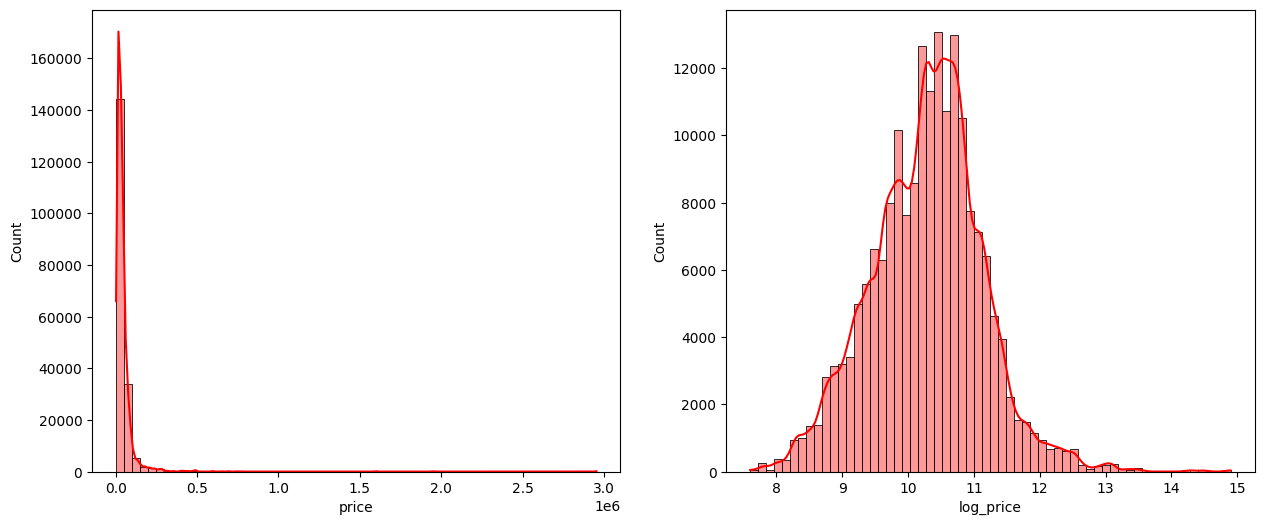

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df_train['price'], color='r', bins=60, ax=ax[0], kde=True, alpha=0.4, edgecolor='black')
sns.histplot(df_train['log_price'], color='r', bins=60, ax=ax[1], kde=True, alpha=0.4, edgecolor='black')
plt.show()

In [27]:
df_train.columns  

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'engine_power', 'engine_size', 'fuel_type_engine',
       'cylinder_configuration', 'vehicle_age', 'fuel_type_reduced',
       'mileage_category', 'model_category', 'brand_category',
       'mileage_per_year', 'high_resale_value', 'vehicle_age_category',
       'recent_model', 'log_price'],
      dtype='object')

In [51]:
categorical_features = ['transmission', 'ext_col', 'int_col', 'fuel_type_engine', 'fuel_type_reduced', 
                        'mileage_category', 'model_category', 'brand_category', 'vehicle_age_category']

numerical_features = ['milage', 'accident', 'clean_title', 'engine_power', 'engine_size',
                      'cylinder_configuration', 'vehicle_age', 'mileage_per_year', 'high_resale_value', 
                      'recent_model']

all_features = categorical_features + numerical_features

In [30]:
for feature in categorical_features:
    print(df_train[feature].value_counts(dropna=False))
    print('_'*40)

transmission
Automatic    152542
Dual          19255
Manual        16431
Unknown         305
Name: count, dtype: int64
________________________________________
ext_col
black     54648
white     47637
grey      27721
silver    19481
blue      16648
red       12204
green      3065
yellow     2680
beige      1272
orange     1192
brown      1185
other       423
purple      354
pink         23
Name: count, dtype: int64
________________________________________
int_col
black     115719
beige      25883
grey       22220
brown       6435
red         5650
white       4863
other       4527
orange      1042
blue         948
silver       467
yellow       436
green        332
purple        11
Name: count, dtype: int64
________________________________________
fuel_type_engine
Gasoline    139734
Unknown      37742
Electric      4980
Diesel        4119
Hybrid        1958
Name: count, dtype: int64
________________________________________
fuel_type_reduced
Gasoline    171346
Hybrid        7353
Unknown   

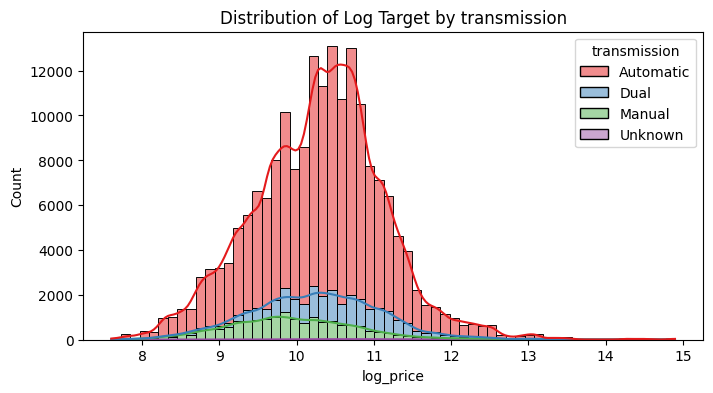

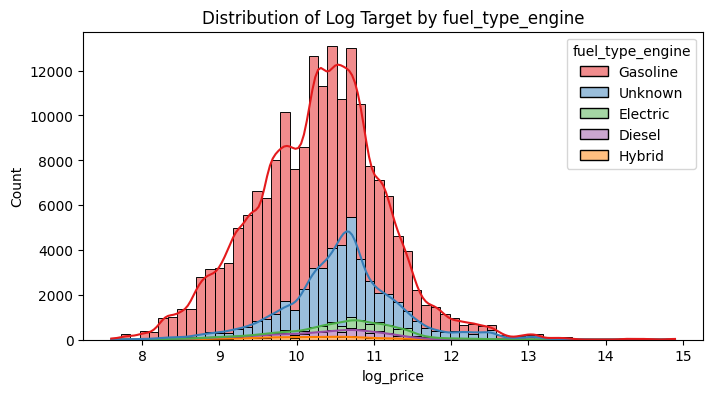

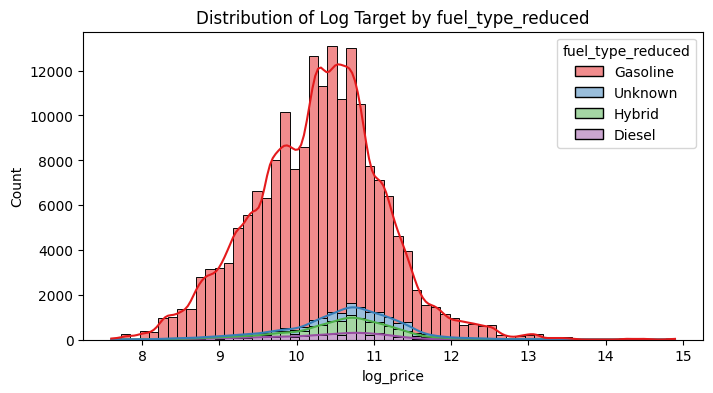

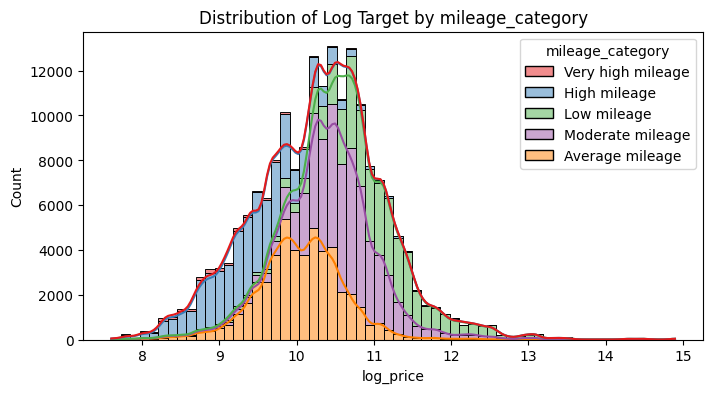

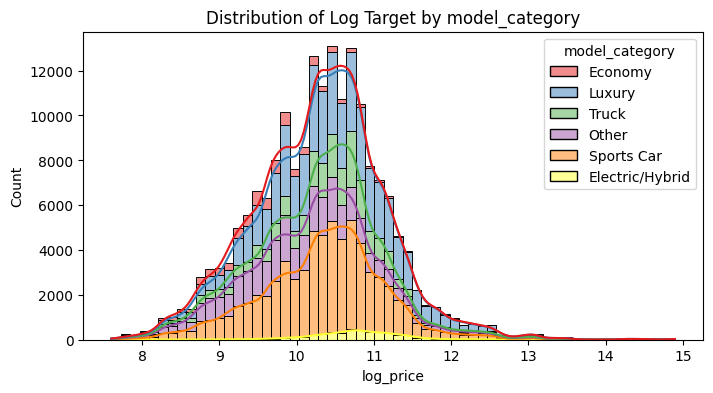

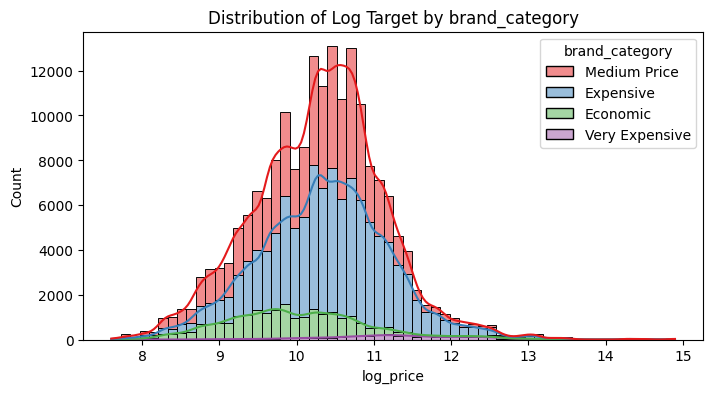

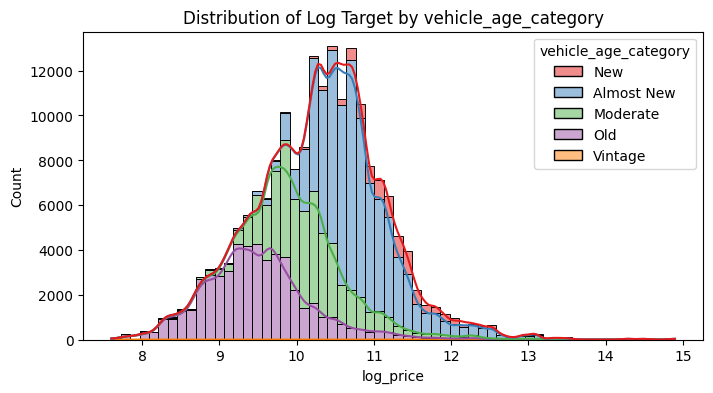

In [31]:
histplot_features = ['transmission', 'fuel_type_engine', 'fuel_type_reduced', 'mileage_category', 
                     'model_category', 'brand_category', 'vehicle_age_category']

for feature in histplot_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_train, x='log_price', hue=feature, bins=60, kde=True, multiple='stack', palette='Set1', alpha=0.5)
    plt.title(f'Distribution of Log Target by {feature}')
    plt.show()

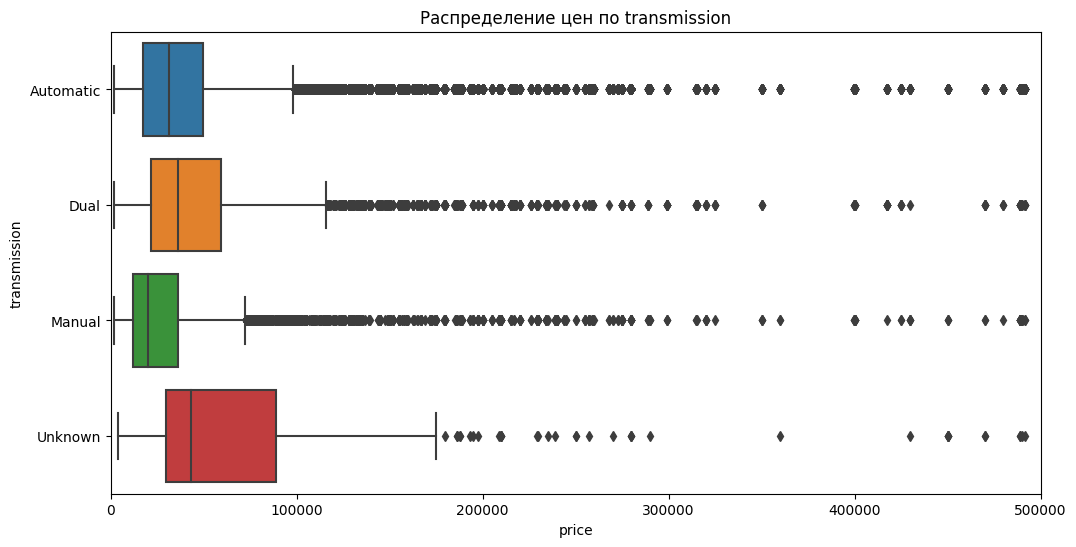

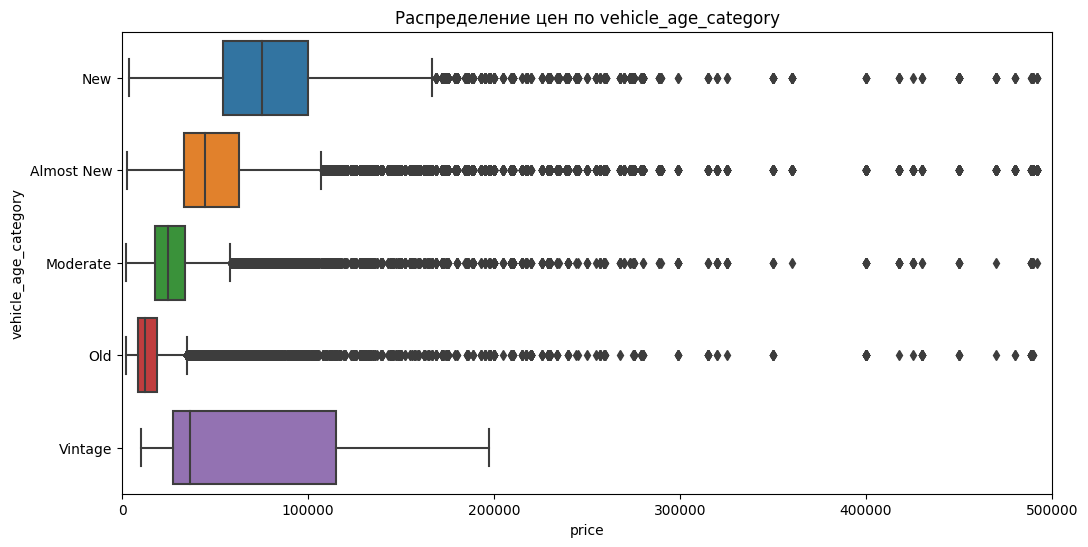

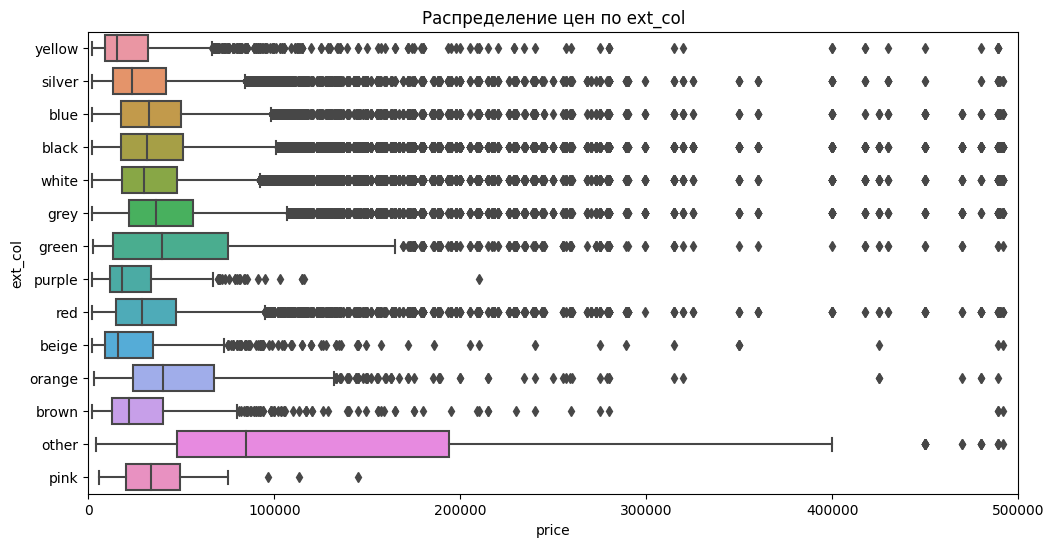

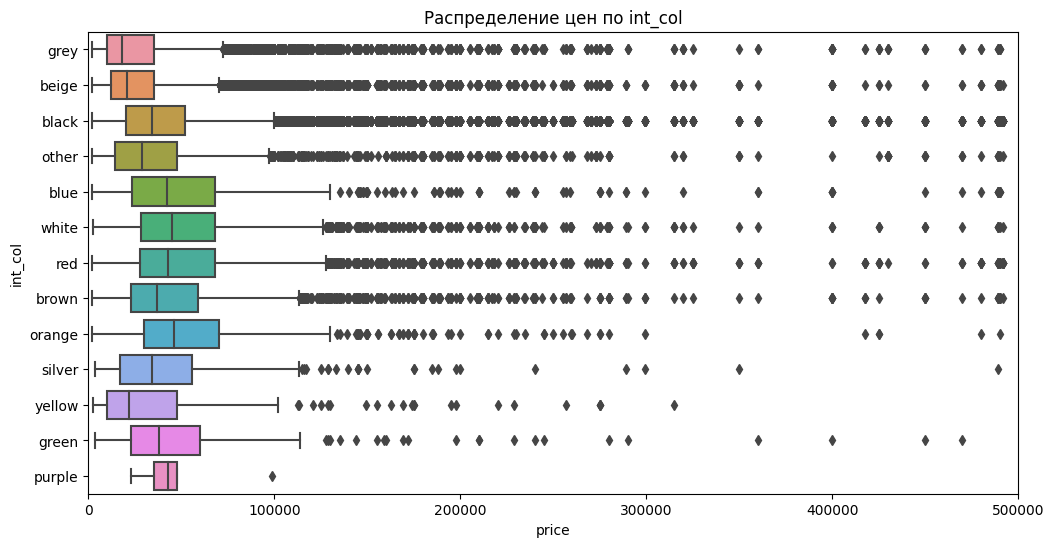

In [32]:
# Unevenly distributed categories in features
for feature in ['transmission', 'vehicle_age_category', 'ext_col', 'int_col']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(y=feature, x='price', data=df_train)
    plt.yticks(rotation=0)
    plt.title(f'Распределение цен по {feature}')
    plt.xlim(0, 500_000) 
    plt.show()

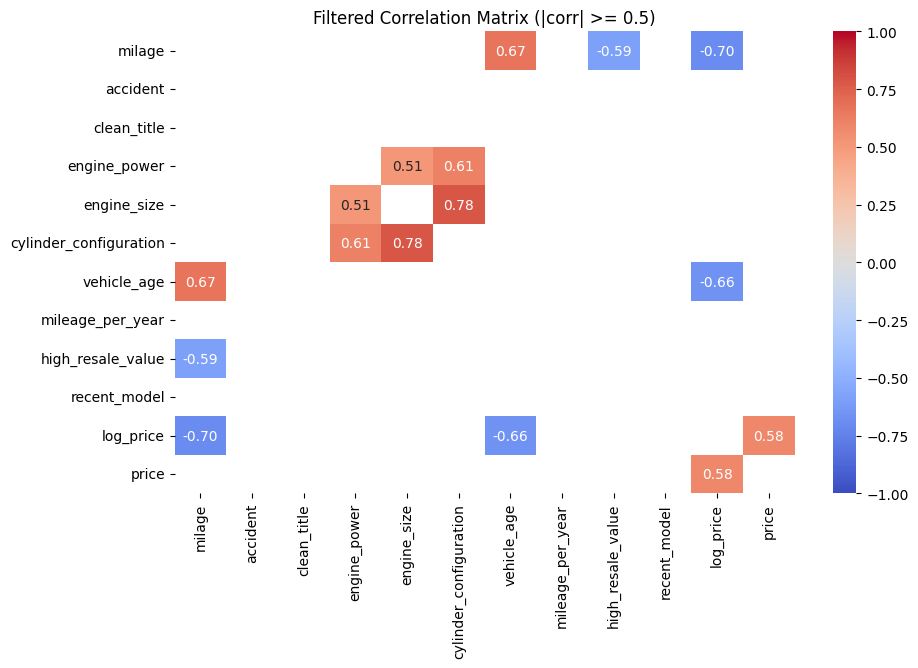

In [33]:
correlation_matrix = df_train[numerical_features+['log_price', 'price']].corr() 
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() >= 0.5) & (correlation_matrix != 1.0)]
        
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, mask=filtered_corr_matrix.isnull())
plt.title('Filtered Correlation Matrix (|corr| >= 0.5)')
plt.show()

# **Model Training and Evaluation**

In [31]:
class TQDMProgressBar(optuna.study.Study):
    def __init__(self, n_trials):
        self.pbar = tqdm(total=n_trials)

    def __call__(self, study, trial):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

# CatBoost

In [38]:
def kfold_cross_val(X, y, param, categorical_features):
    kf = KFold(n_splits=4, shuffle=True, random_state=777)
    train_metrics, val_metrics, diff_metrics = [], [], []
    
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        train_pool = Pool(X_train, y_train, cat_features=categorical_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features)
    
        model = CatBoostRegressor(**param)
        model.fit(train_pool, eval_set=valid_pool, #early_stopping_rounds=20, 
                  verbose=False)

        preds = model.predict(X_valid)
        val_rmse = np.sqrt(mean_squared_error(y_valid, preds))
        val_metrics.append(val_rmse)
        
        preds = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, preds))
        train_metrics.append(train_rmse)
        
        diff_metrics.append(abs(train_rmse - val_rmse))
        
    return train_metrics, val_metrics, diff_metrics

In [33]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 2, 6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'verbose': 0,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE'
    }
    
    train_metrics, val_metrics, diff_metrics = kfold_cross_val(X, y, param, categorical_features)
    
    print(f'Train folds: {np.mean(train_metrics):.02f}')    
    print(f'Test folds: {np.mean(val_metrics):.02f}')
    print(f'Diff: {np.mean(diff_metrics):.02f}')
    print('-'*20)
    
    return np.mean(diff_metrics), np.mean(val_metrics)

In [34]:
X = df_train[categorical_features+numerical_features]
y = df_train['price']

In [78]:
n_trials = 20

progress_bar = TQDMProgressBar(n_trials)

study = optuna.create_study(directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

  0%|          | 0/20 [00:00<?, ?it/s][I 2024-10-03 16:30:54,719] A new study created in memory with name: no-name-5f294c2e-e17a-427a-9ef8-50b1e72a1d83
[I 2024-10-03 16:36:44,221] Trial 0 finished with values: [6997.979260082007, 72792.59416660729] and parameters: {'iterations': 648, 'depth': 5, 'learning_rate': 0.015458242918413537}. 
  5%|▌         | 1/20 [05:49<1:50:40, 349.50s/it]

Train folds: 72549.56
Test folds: 72792.59
Diff: 6997.98
--------------------


[I 2024-10-03 16:39:11,121] Trial 1 finished with values: [6845.926802063183, 74867.47913355439] and parameters: {'iterations': 218, 'depth': 6, 'learning_rate': 0.0030472610684132238}. 
 10%|█         | 2/20 [08:16<1:09:05, 230.32s/it]

Train folds: 74995.52
Test folds: 74867.48
Diff: 6845.93
--------------------


[I 2024-10-03 16:40:26,668] Trial 2 finished with values: [6734.223150485082, 76347.78385997946] and parameters: {'iterations': 253, 'depth': 3, 'learning_rate': 0.001464808275708505}. 
 15%|█▌        | 3/20 [09:31<45:14, 159.65s/it]  

Train folds: 76518.25
Test folds: 76347.78
Diff: 6734.22
--------------------


[I 2024-10-03 16:43:07,597] Trial 3 finished with values: [6886.665475943799, 74304.39366037205] and parameters: {'iterations': 388, 'depth': 4, 'learning_rate': 0.0026348138007086038}. 
 20%|██        | 4/20 [12:12<42:42, 160.16s/it]

Train folds: 74465.36
Test folds: 74304.39
Diff: 6886.67
--------------------


[I 2024-10-03 16:44:53,672] Trial 4 finished with values: [6978.528204248891, 72917.47790465708] and parameters: {'iterations': 589, 'depth': 2, 'learning_rate': 0.028311688587056506}. 
 25%|██▌       | 5/20 [13:58<35:09, 140.65s/it]

Train folds: 73025.00
Test folds: 72917.48
Diff: 6978.53
--------------------


[I 2024-10-03 16:48:26,932] Trial 5 finished with values: [6961.043475777558, 73256.8319645513] and parameters: {'iterations': 701, 'depth': 3, 'learning_rate': 0.00426717201750388}. 
 30%|███       | 6/20 [17:32<38:34, 165.34s/it]

Train folds: 73395.78
Test folds: 73256.83
Diff: 6961.04
--------------------


[I 2024-10-03 16:52:39,522] Trial 6 finished with values: [6976.465677563097, 72954.1691673034] and parameters: {'iterations': 603, 'depth': 4, 'learning_rate': 0.008174516595988323}. 
 35%|███▌      | 7/20 [21:44<42:00, 193.86s/it]

Train folds: 72985.10
Test folds: 72954.17
Diff: 6976.47
--------------------


[I 2024-10-03 16:52:53,588] Trial 7 finished with values: [6953.177973977734, 73475.90759080948] and parameters: {'iterations': 100, 'depth': 2, 'learning_rate': 0.031346853620735686}. 
 40%|████      | 8/20 [21:58<27:19, 136.62s/it]

Train folds: 73645.63
Test folds: 73475.91
Diff: 6953.18
--------------------


[I 2024-10-03 16:57:35,900] Trial 8 finished with values: [6868.659548986434, 74541.74536159576] and parameters: {'iterations': 527, 'depth': 5, 'learning_rate': 0.001568580604239465}. 
 45%|████▌     | 9/20 [26:41<33:23, 182.17s/it]

Train folds: 74689.71
Test folds: 74541.75
Diff: 6868.66
--------------------


[I 2024-10-03 17:00:28,617] Trial 9 finished with values: [6945.2817149528455, 73557.2678619371] and parameters: {'iterations': 908, 'depth': 2, 'learning_rate': 0.0031440838449271246}. 
 50%|█████     | 10/20 [29:33<29:52, 179.25s/it]

Train folds: 73725.48
Test folds: 73557.27
Diff: 6945.28
--------------------


[I 2024-10-03 17:02:20,513] Trial 10 finished with values: [6888.740449114255, 74321.5723828828] and parameters: {'iterations': 360, 'depth': 3, 'learning_rate': 0.003220770296892332}. 
 55%|█████▌    | 11/20 [31:25<23:47, 158.64s/it]

Train folds: 74489.88
Test folds: 74321.57
Diff: 6888.74
--------------------


[I 2024-10-03 17:07:36,151] Trial 11 finished with values: [6884.329451970767, 74346.93343508706] and parameters: {'iterations': 770, 'depth': 4, 'learning_rate': 0.0012913423606217094}. 
 60%|██████    | 12/20 [36:41<27:31, 206.40s/it]

Train folds: 74509.02
Test folds: 74346.93
Diff: 6884.33
--------------------


[I 2024-10-03 17:09:57,772] Trial 12 finished with values: [6970.183370089038, 73117.3501386584] and parameters: {'iterations': 791, 'depth': 2, 'learning_rate': 0.00825529576001079}. 
 65%|██████▌   | 13/20 [39:03<21:47, 186.78s/it]

Train folds: 73264.04
Test folds: 73117.35
Diff: 6970.18
--------------------


[I 2024-10-03 17:12:32,117] Trial 13 finished with values: [6979.260299017395, 72810.17493556926] and parameters: {'iterations': 368, 'depth': 4, 'learning_rate': 0.028818161665920765}. 
 70%|███████   | 14/20 [41:37<17:41, 176.98s/it]

Train folds: 72717.29
Test folds: 72810.17
Diff: 6979.26
--------------------


[I 2024-10-03 17:16:07,555] Trial 14 finished with values: [7025.619847557675, 72730.6128519987] and parameters: {'iterations': 409, 'depth': 5, 'learning_rate': 0.04303010936506023}. 
 75%|███████▌  | 15/20 [45:12<15:42, 188.57s/it]

Train folds: 72340.46
Test folds: 72730.61
Diff: 7025.62
--------------------


[I 2024-10-03 17:21:08,022] Trial 15 finished with values: [7006.788435104936, 72827.55991921827] and parameters: {'iterations': 557, 'depth': 5, 'learning_rate': 0.013415357162849237}. 
 80%|████████  | 16/20 [50:13<14:49, 222.25s/it]

Train folds: 72644.76
Test folds: 72827.56
Diff: 7006.79
--------------------


[I 2024-10-03 17:25:55,686] Trial 16 finished with values: [6963.831673504679, 72697.96833263269] and parameters: {'iterations': 548, 'depth': 5, 'learning_rate': 0.048200882507913476}. 
 85%|████████▌ | 17/20 [55:00<12:05, 241.92s/it]

Train folds: 72115.10
Test folds: 72697.97
Diff: 6963.83
--------------------


[I 2024-10-03 17:30:26,415] Trial 17 finished with values: [6999.9956242178705, 72711.7548624756] and parameters: {'iterations': 933, 'depth': 3, 'learning_rate': 0.05542892461218219}. 
 90%|█████████ | 18/20 [59:31<08:21, 250.58s/it]

Train folds: 72383.74
Test folds: 72711.75
Diff: 7000.00
--------------------


[I 2024-10-03 17:32:58,859] Trial 18 finished with values: [6983.807848364591, 72794.46561003526] and parameters: {'iterations': 371, 'depth': 4, 'learning_rate': 0.033587215112000024}. 
 95%|█████████▌| 19/20 [1:02:04<03:41, 221.10s/it]

Train folds: 72659.75
Test folds: 72794.47
Diff: 6983.81
--------------------


[I 2024-10-03 17:36:34,034] Trial 19 finished with values: [6885.320060388414, 74325.48733878924] and parameters: {'iterations': 402, 'depth': 5, 'learning_rate': 0.002304089317905789}. 
100%|██████████| 20/20 [1:05:39<00:00, 196.97s/it]

Train folds: 74468.75
Test folds: 74325.49
Diff: 6885.32
--------------------


In [80]:
study.trials_dataframe().sort_values(['values_1'])

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_depth,params_iterations,params_learning_rate,system_attrs_nsga2:generation,state
16,16,6963.831674,72697.968333,2024-10-03 17:21:08.024924,2024-10-03 17:25:55.685916,0 days 00:04:47.660992,5,548,0.048201,0,COMPLETE
17,17,6999.995624,72711.754862,2024-10-03 17:25:55.688295,2024-10-03 17:30:26.415119,0 days 00:04:30.726824,3,933,0.055429,0,COMPLETE
14,14,7025.619848,72730.612852,2024-10-03 17:12:32.119999,2024-10-03 17:16:07.555137,0 days 00:03:35.435138,5,409,0.043030,0,COMPLETE
0,0,6997.979260,72792.594167,2024-10-03 16:30:54.720681,2024-10-03 16:36:44.221652,0 days 00:05:49.500971,5,648,0.015458,0,COMPLETE
18,18,6983.807848,72794.465610,2024-10-03 17:30:26.417811,2024-10-03 17:32:58.858873,0 days 00:02:32.441062,4,371,0.033587,0,COMPLETE
13,13,6979.260299,72810.174936,2024-10-03 17:09:57.775135,2024-10-03 17:12:32.117344,0 days 00:02:34.342209,4,368,0.028818,0,COMPLETE
15,15,7006.788435,72827.559919,2024-10-03 17:16:07.557778,2024-10-03 17:21:08.022590,0 days 00:05:00.464812,5,557,0.013415,0,COMPLETE
4,4,6978.528204,72917.477905,2024-10-03 16:43:07.599800,2024-10-03 16:44:53.671770,0 days 00:01:46.071970,2,589,0.028312,0,COMPLETE
6,6,6976.465678,72954.169167,2024-10-03 16:48:26.934567,2024-10-03 16:52:39.522005,0 days 00:04:12.587438,4,603,0.008175,0,COMPLETE
12,12,6970.183370,73117.350139,2024-10-03 17:07:36.153525,2024-10-03 17:09:57.772266,0 days 00:02:21.618741,2,791,0.008255,0,COMPLETE


In [36]:
best_params = study.trials[16].params  # {'iterations': 548, 'depth': 5, 'learning_rate': 0.048200882507913476}
best_params

{'iterations': 548, 'depth': 5, 'learning_rate': 0.048200882507913476}

In [39]:
train_metrics, val_metrics, diff_metrics = kfold_cross_val(X, y, best_params, categorical_features)

for fold_index in range(4):
    print(f'Train folds: {train_metrics[fold_index]:.02f}')    
    print(f'Test folds: {val_metrics[fold_index]:.02f}')
    print(f'Diff: {abs(val_metrics[fold_index] - train_metrics[fold_index]):.02f}')
    print('-'*20)

Train folds: 69272.90
Test folds: 80944.30
Diff: 11671.40
--------------------
Train folds: 71413.52
Test folds: 74835.52
Diff: 3422.00
--------------------
Train folds: 73660.46
Test folds: 68610.33
Diff: 5050.13
--------------------
Train folds: 74113.52
Test folds: 66401.72
Diff: 7711.79
--------------------


In [40]:
final_model = CatBoostRegressor(**best_params, cat_features=categorical_features, silent=True)
final_model.fit(X, y)

In [41]:
y_test_pred = final_model.predict(df_test[categorical_features+numerical_features])
y_train_pred = final_model.predict(X)

train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))
print(f'Train RMSE: {train_rmse}')

Train RMSE: 72141.6699256934


In [52]:
def feature_selection(X, y, best_params, cat_features, min_features=1):
    features = list(X.columns)
    best_rmse = float('inf')
    best_features = features.copy()
    
    while len(features) > min_features:
        rmse_values = []
        
        for feature in tqdm(features, desc="Feature selection progress"):
            temp_features = [f for f in features if f != feature]
            
            cur_cat_features = [f for f in cat_features if f in temp_features]
            if feature in cat_features:
                cur_cat_features = cat_features.copy()
                cur_cat_features.remove(feature)
            
            model = CatBoostRegressor(**best_params, cat_features=cur_cat_features, silent=True)
            model.fit(X[temp_features], y)
            
            y_pred = model.predict(X[temp_features])
            rmse = mean_squared_error(y, y_pred, squared=False)
            rmse_values.append((rmse, feature))
        
        rmse_values.sort()
        current_best_rmse, feature_to_remove = rmse_values[0]
        
        if current_best_rmse >= best_rmse:
            break
        
        best_rmse = current_best_rmse
        best_features.remove(feature_to_remove)
        features.remove(feature_to_remove)
        if feature_to_remove in cat_features:
            cat_features.remove(feature_to_remove)
    
    print(f'Best feature set: {best_features}')
    print(f'Best RMSE: {best_rmse}')
    return best_features

In [53]:
selected_features = feature_selection(X, y, best_params, categorical_features)

Feature selection progress: 100%|██████████| 13/13 [09:01<00:00, 41.66s/it]

Best feature set: ['ext_col', 'fuel_type_reduced', 'model_category', 'brand_category', 'milage', 'clean_title', 'engine_power', 'engine_size', 'cylinder_configuration', 'vehicle_age', 'mileage_per_year', 'high_resale_value', 'recent_model']
Best RMSE: 71618.25470863024


In [54]:
updated_categorical_features = [feature for feature in categorical_features if feature in selected_features]

In [56]:
selected_final_model = CatBoostRegressor(**best_params, cat_features=updated_categorical_features, silent=True)
selected_final_model.fit(X[selected_features], y)

In [57]:
y_test_pred_selected = selected_final_model.predict(df_test[selected_features])

# **Saving**

In [58]:
df_test['price'] = y_test_pred_selected

In [59]:
df_test[['id', 'price']].to_csv('submission.csv', index=False)
df_test[['id', 'price']]

,id,price
0,188533,17479.594426
1,188534,76693.896489
2,188535,53678.032769
3,188536,27287.506991
4,188537,30550.495400
...,...,...
125685,314218,26926.040492
125686,314219,49949.038770
125687,314220,24690.466252
125688,314221,18577.725836
